$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Dots and Boxes

Jeffrey Buehler<br>
Bobby Signor

## The Game

#### Setup
    Dots and Boxes is a simple game for two players. The gameboard consists of x dots across by y dots up and down. kkkke 

    ex: An empty 5 x 5 board will look like this
                            *   *   *   *   *
                                 
                            *   *   *   *   *
                                 
                            *   *   *   *   *
                                 
                            *   *   *   *   *
                                 
                            *   *   *   *   *

#### Rules
    Each player switch off taking turns. A turn consists of drawing a line between two unoccupied side-by-side dots. If the new line the player
    draws does not complete a 1 x 1 square, then that player's turn is over and it is the other player's turn.

    ex:
                *   *   *   *   *              *   *   *   *   *
                                                                
                *   *---*   *   *              *   *---*   *   *
                    |                              |            
                *   *   *   *   *     ->       *   *---*   *   *
                                                                
                *   *   *   *   *              *   *   *   *   *
                                                                
                *   *   *   *   *              *   *   *   *   *
                
                        Results in next player's turn


    If the player draws a line that completes a 1 x 1 square, the player is rewarded that box and the player takes their turn again.
    
    ex:
                *   *   *   *   *              *   *   *   *   *
                                                                
                *   *---*   *   *              *   *---*   *   *
                    |                              | x |        
                *   *---*   *   *     ->       *   *---*   *   *
                                                                
                *   *   *   *   *              *   *   *   *   *
                                                                
                *   *   *   *   *              *   *   *   *   *
                      Results in owning the box and
                            a repeated turn

    The game ends when it is no longer possible to draw another line.
    ex:
        
                            *---*---*---*---*
                            | x | x | o | x |
                            *---*---*---*---*
                            | x | x | x | o |
                            *---*---*---*---*
                            | o | o | o | x |
                            *---*---*---*---*
                            | x | o | x | x |
                            *---*---*---*---*
                               where x: 10
                                     y: 6

    The winner is determined by whoever has the most boxes at the end of
    the game. In our example, player x would be the winner.


#### Strategy
The objective of the game is to score as many boxes as possible, however it is not always wise to complete boxes as quick as possible. One strategy that is quickly learned by human opponents is creating paths that can be completed in succession (fig. 1). Creating and fillint out paths will maximize point output by giving you more opportunities to draw lines and fill boxes. This must be done with discression however, since your opponent may also complete your path, giving them all of the potential points.

    fig. 1
                *   *   *   *   *              *-8-*   *   *   *
                |   |                          |   |            
                *   *   *   *   *              *-7-*   *   *   *
                |   |                          |   |            
                *   *---*---*   *     ->       *-6-*---*---*   *
                |   |       |                  |   |   2   |    
                *   *   *   *   *              *-5-*-3-*-1-*   *
                |       |   |                  |   4   |   |    
                *---*---*---*   *              *---*---*---*   *
                         This results in a +8 score
                               all in one turn

## The Code

#### Game
The Game object stores information relevant to the game board and environment. Board has all spaces available to play on stored as a numpy array of tuples. Each player's score is kept track of inside of game as well.

#### Players
There are two types of players that can be created.
 1. Random Player: This player chooses moves simply by looking at all of the available moves on the board and choosing one at random. It does not learn, nor improve as each game goes by.
 2. AI Player: This player uses Reinforcement Learning (see below) to learn from past games and moves which next possible move would result in a higher percentage win. It will start the first few games by choosing random moves, like the Random Player, but will start choosing higher probability moves at an exponential rate as games go on and it learns better.

## The Machine Learning Method: Reinforcement Programming

#### Reinforcement Learning
Reinforcement learning is a method of machine learning used to teach a program to give correct output given input using reward/punishment. The behavior of a reinforced program is based on the psychological response of humans trying to suceed at a task. One way to picture this is to imagine a child being taught how to read by a grade-school teacher. They are presented with simple words and are asked to sound out the word. If presented incorrectly, the teacher will inform the child they were wrong and give feedback on how to improve. If the child pronounces the word correctly, they are given positive feedback, and sometimes some sort of reward. Eventually, the child will learn that certain letters interact with others in certian ways because they were given positive reinforcement when they did something correct.

#### Applied to AI Player
We will be applying reinforcement learning to our AI Player. It will be reinforced depending on the moves it makes that end up winning a game. Positive reinforcement will be given whenever the AI is able to win a game. The decisions the AI makes will be determined on past experience of winning moves.

## Required Code

In [180]:
# Code imports
import game
import players
import time

# Graph imports
%pylab inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from pylab import *

Populating the interactive namespace from numpy and matplotlib


C:\Users\jeffs\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['info', 'draw_if_interactive', 'fft', 'random', 'linalg', 'power']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [219]:
def playTestvsRandom(p1, p2):
    start = time.time()
    aiWins = 0
    winPercent = {}
    for i in range(trainIterations):
        g = game.Game()
        if i % 2 is 0:
            g.play(p1, p2, printturns=printturns)
        else:
            g.play(p2, p1, printturns=printturns)
        if g.score.index(max(g.score)) is p1.playernum:
            aiWins += 1
        p1.epsilon *= epsilonDecay
        winPercent[i] = aiWins / (i + 1)
    print("Train vs. Random:\t{} wins out of {}".format(aiWins, trainIterations))
    print("Took ", time.time() - start, "seconds.\n")
    return winPercent

def playTrainvsRandom(p1, p2):
    start = time.time()
    aiWins = 0
    p1.train = False
    for i in range(randTestIterations):
        g = game.Game()
        if i % 2 is 0:
            g.play(p1, p2, printturns=printturns)
        else:
            g.play(p2, p1, printturns=printturns)
        if g.score.index(max(g.score)) is p1.playernum:
            aiWins += 1
    print("Test vs. Random:\t{} wins out of {}".format(aiWins, randTestIterations))
    print("Took ", time.time() - start, "seconds.\n")

def playTrainvsSelf(p1, p2):
    start = time.time()
    wins = [0, 0]
    p1.train = True
    p1.epsilon = initialEpsilon
    p2 = players.AIPlayer(rho=rho, epsilon=initialEpsilon, seed=seed2)
    p2.Q = p1.Q
    for i in range(aiTrainIterations):
        g = game.Game()
        g.play(p1, p2, printturns=False)
        wins[g.score.index(max(g.score))] += 1
        p1.epsilon *= epsilonDecay
        p2.epsilon *= epsilonDecay
    print("Train vs. Self:\t{} wins to {} wins".format(wins[0], wins[1]))
    print("Took ", time.time() - start, "seconds.\n")

def playTestvsSelf(p1, p2):
    start = time.time()
    wins = [0, 0]
    p1.train = False
    p2.train = False
    for i in range(aiTestIterations):
        g = game.Game()
        g.play(p1, p2, printturns=False)
        wins[g.score.index(max(g.score))] += 1
    print("Test vs. Self:\t{} wins to {} wins".format(wins[0], wins[1]))
    print("Took ", time.time() - start, "seconds.\n")

In [215]:
def play(p1, p2):
    winPercentage = playTestvsRandom(p1, p2)
    playTrainvsRandom(p1, p2)

    print("--------------------------------------------")

    playTrainvsSelf(p1, p2)
    playTestvsSelf(p1, p2)
    return winPercentage

In [210]:
def graph_all(board):
    graph_board(board)

def graph_epsilon():
    return 0

def graph_board(board):
    x = list(range(board.shape[1]))
    y = list(range(board.shape[1]))
    plt.plot(board.shape[1] - 1, board.shape[1] - 1)
    plt.xlim(-1,board.shape[1])
    plt.ylim(-1,board.shape[1])
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    
    for i in x:
        for j in y:
            plt.scatter(i, j)
    
    for r in range(board.shape[0]):
        for c in range(board.shape[1] - 1):
            if board[r, c] == True:
                if r % 2 == 0:
                    x, y = [c, c + 1], [int(r / 2), int(r / 2)]
                    plt.plot(x, y)
                else:
                    x, y = [c, c], [int(r / 2), int(r / 2) + 1]
                    plt.plot(x, y)

def graph_win_percentage(winPercent):
    lowest = 1
    for key, value in winPercent.items():
        if value < lowest:
            lowest = value
        plt.scatter(key, value)
    plt.xlim(0, len(winPercent))
    plt.ylim(lowest - .01, 1)
    xlabel('Games')
    ylabel('Win (%)')
    title('Games Won by Percentage')

•  • ── •  •  •  •
    |          |      
•  •  •  •  • ── •
                        
• ── •  •  • ── •  •
|          |          
•  •  •  •  •  •
                        
• ── •  • ── •  • ── •
                        
•  •  •  •  •  •



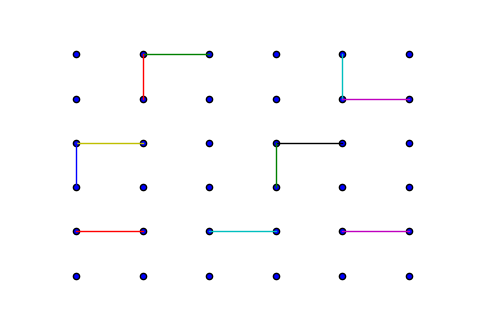

In [183]:
g = game.Game()
b = g.board
b[1, 1] = True
b[1, 4] = True
b[5, 0] = True
b[5, 3] = True

b[0, 1] = True
b[2, 4] = True
b[4, 0] = True
b[4, 3] = True
b[8, 0] = True
b[8, 2] = True
b[8, 4] = True

graph_board(b)
print(g)

# Observation 1

In [184]:
rho = rho = 0.2
initialEpsilon = 1.0
epsilonDecay = 0.99
seed1 = None
seed2 = None

printturns = False

trainIterations = 2000
randTestIterations = 200
aiTrainIterations = 2000
aiTestIterations = 200
rho = 0.2
initialEpsilon = 1.0
epsilonDecay = 0.99
seed1 = None
seed2 = None

trainIterations = 2000
randTestIterations = 200
aiTrainIterations = 2000
aiTestIterations = 200

p1 = players.AIPlayer(rho=rho, epsilon=initialEpsilon, seed=seed1)
p2 = players.RandomPlayer(seed=None)

Train vs. Random:	1997 wins out of 2000
Took  5.693087339401245 seconds.

Test vs. Random:	199 wins out of 200
Took  0.5687391757965088 seconds.

--------------------------------------------
Train vs. Self:	1322 wins to 678 wins
Took  10.43252682685852 seconds.

Test vs. Self:	200 wins to 0 wins
Took  0.586733341217041 seconds.



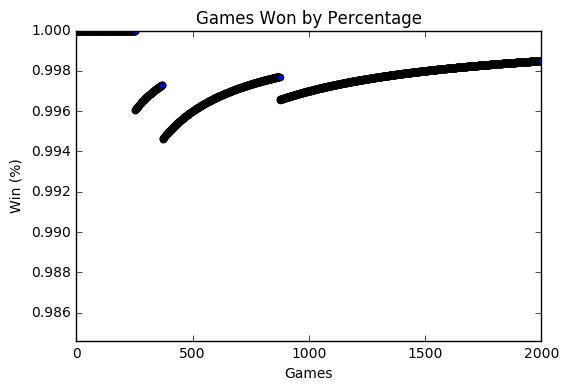

In [220]:
winPercent = play(p1, p2)
graph_win_percentage(winPercent)

# Observation 2

# Observation 3

# Observation 4